# **Data Analysis and Feature Engineering for Delivery Dataset**

## **1. Analytical Question**
To drive a meaningful investigation, I define the following analytical question:

> **"What are the key factors influencing delivery time, and how can I predict delivery efficiency based on delivery personnel characteristics, weather conditions, and traffic levels?"**

This question will help guide my analysis toward uncovering the most influential variables affecting delivery times, ultimately aiding in building a predictive model for delivery time estimation.


## **2. Feature Engineering**
To enhance predictive power, I introduce **six new features** while ensuring they do not cause target leakage.

### **1. Traffic Density Score**
**Formula:**  
$ \text{Traffic Density Score} = \text{Traffic Level} \times \text{Distance (km)} $

- **Why?** This feature measures the expected congestion effect on delivery times, as longer distances in high-traffic conditions are likely to take more time.


### **2. Weather Impact Score**
**Formula:**  
$ \text{Weather Impact Score} = \text{humidity} + \text{precipitation} + \text{weather description} $

- **Why?** Combines multiple weather factors into a single numerical value to understand how environmental conditions affect delivery time.


### **3. Experience-Adjusted Ratings**
**Formula:**  
$ \text{Experience Score} = \text{Delivery Person Age} \times \text{Delivery Person Ratings} $

- **Why?** Assesses whether more experienced delivery personnel tend to receive higher ratings and if this correlates with better efficiency.


### **4. Weather Severity Indicator**
**Formula:**  
$ \text{Weather Severity} = \frac{\text{humidity} + \text{precipitation}}{2} $

- **Why?** Averages humidity and precipitation to create a simplified weather severity index, indicating potential delivery delays.

Here’s **Point 5: Haversine Distance** formatted properly for Jupyter Notebook and Markdown without using LaTeX dollar signs to avoid rendering issues:


### **5. Haversine Distance**

**Formula:**
Haversine Distance is calculated using the following formula:

```
Haversine Distance = 2 * R * arcsin( sqrt( sin²(Δφ / 2) + cos(φ₁) * cos(φ₂) * sin²(Δλ / 2) ) )
```

Where:
- **R** = Earth's radius (≈ 6371 km)
- **φ₁, φ₂** = Latitudes (in radians) of the restaurant and delivery location
- **λ₁, λ₂** = Longitudes (in radians) of the restaurant and delivery location
- **Δφ = φ₂ - φ₁**
- **Δλ = λ₂ - λ₁**

**Why?**  
Haversine distance calculates the great-circle distance between the restaurant and delivery location. This provides a more accurate measurement of actual geographic distance rather than just Euclidean or road-based distances.



This structured approach ensures that my dataset is well-prepared for predictive modeling and insightful analysis while avoiding target leakage.


In [3]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'msds610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'Harideep' # this is the password established during installation
port = r'5432' # default port estabalished during install
schema = r'raw' # schema we just created

In [4]:
from sqlalchemy import create_engine

# create a connection to the database
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{db}')
connection = engine.connect()

In [5]:
# Using Raw Data and performing same Data processing like in week 3. Because in last week assignment 
# I did data normalization because which I cannot extract thesse new features

# Pulling the data from the delivery_data table
import pandas as pd
query = 'SELECT * FROM raw.delivery_data;'
delivery_data = pd.read_sql_query(query, connection)
delivery_data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Unnamed: 14,Traffic_Level,Distance (km),TARGET
0,4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,17.11,77.0,0.0,haze,None,Low,NaN,21.66666667
1,B379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,19.50,93.0,0.0,mist,None,Very High,37.17,85.26666667
2,5D6D,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,20.45,91.0,0.0,mist,None,Low,3.34,28.58333333
3,7A6A,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,23.86,78.0,0.0,mist,None,Moderate,10.05,35.18333333
4,70A2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,26.55,87.0,0.0,mist,None,High,9.89,43.45


In [6]:
# Dropping the missing values abd column Unnamed: 14
delivery_data.drop(columns=['Unnamed: 14'], inplace=True)
delivery_data.dropna(inplace=True)
delivery_data.isnull().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
temperature                    0
humidity                       0
precipitation                  0
weather_description            0
Traffic_Level                  0
Distance (km)                  0
TARGET                         0
dtype: int64

In [7]:
# Catagozing the traffic level to numerical values
traffic_level = {'Very High': 4, 'High': 3, 'Moderate': 2, 'Low': 1, 'Very Low': 0}
weather_description = delivery_data.weather_description.unique()
Type_of_order = delivery_data.Type_of_order.unique()
Type_of_vehicle = delivery_data.Type_of_vehicle.unique()

# Create a dictionary for the weather_description, Type_of_order and Type_of_vehicle with numerical values
weather_description_dict = {weather_description[i]: i for i in range(len(weather_description))}
Type_of_order_dict = {Type_of_order[i]: i for i in range(len(Type_of_order))}
Type_of_vehicle_dict = {Type_of_vehicle[i]: i for i in range(len(Type_of_vehicle))}

In [8]:
# Converting the weather_description, Type_of_order and Type_of_vehicle to numerical values
delivery_data['Traffic_Level'] = delivery_data['Traffic_Level'].map(traffic_level)
delivery_data['weather_description'] = delivery_data['weather_description'].map(weather_description_dict)
delivery_data['Type_of_order'] = delivery_data['Type_of_order'].map(Type_of_order_dict)
delivery_data['Type_of_vehicle'] = delivery_data['Type_of_vehicle'].map(Type_of_vehicle_dict)

In [9]:
delivery_data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Traffic_Level,Distance (km),TARGET
1,B379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,0,0,19.50,93.0,0.0,0,4,37.17,85.26666667
2,5D6D,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,1,1,20.45,91.0,0.0,0,1,3.34,28.58333333
3,7A6A,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2,1,23.86,78.0,0.0,0,2,10.05,35.18333333
4,70A2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,0,0,26.55,87.0,0.0,0,3,9.89,43.45
5,9BB4,HYDRES09DEL03,22.0,4.8,17.431668,78.408321,17.461668,78.438321,2,1,21.43,65.0,0.0,1,2,11.30,30.6


In [10]:
# Parameter Extraction Haversine Distance: The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):

    # Radius of the Earth in km
    R = 6371.0

    # Converting latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Calculating the change in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2

    return a

In [11]:
delivery_data['haversine_distance'] = haversine_distance(delivery_data['Restaurant_latitude'], 
                                                         delivery_data['Restaurant_longitude'], 
                                                         delivery_data['Delivery_location_latitude'], 
                                                         delivery_data['Delivery_location_longitude'])

In [12]:
# Dropping the columns that are not needed
delivery_data.drop(columns=['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude'], inplace=True)

In [13]:
delivery_data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Traffic_Level,Distance (km),TARGET,haversine_distance
1,B379,BANGRES18DEL02,34.0,4.5,0,0,19.50,93.0,0.0,0,4,37.17,85.26666667,2.509104e-06
2,5D6D,BANGRES19DEL01,23.0,4.4,1,1,20.45,91.0,0.0,0,1,3.34,28.58333333,1.485020e-08
3,7A6A,COIMBRES13DEL02,38.0,4.7,2,1,23.86,78.0,0.0,0,2,10.05,35.18333333,3.738044e-07
4,70A2,CHENRES12DEL01,32.0,4.6,0,0,26.55,87.0,0.0,0,3,9.89,43.45,2.375348e-07
5,9BB4,HYDRES09DEL03,22.0,4.8,2,1,21.43,65.0,0.0,1,2,11.30,30.6,1.309168e-07


In [14]:
# 1. Traffic Density Score = Traffic Level * Distance (km)
delivery_data['Traffic_Density_Score'] = delivery_data['Traffic_Level'] * delivery_data['Distance (km)']

# 2. Weather Impact Score = humidity + precipitation + weather description
delivery_data['Weather_Impact_Score'] = delivery_data['humidity'] + delivery_data['precipitation'] + delivery_data['weather_description']

In [15]:
# 3. Experience-Adjusted Ratings = Delivery Person Age * Delivery Person Ratings
delivery_data['Experience_Adjusted_Ratings'] = delivery_data['Delivery_person_Age'] * delivery_data['Delivery_person_Ratings']

In [16]:
# 5. Location-Based Delivery Time Estimation:
# Bin 'Distance (km)' into intervals (e.g., 0-1 km, 1-2 km, 2-4 km, and 4+ km)
bins = [0, 1, 2, 4, np.inf]
labels = ['0-1', '1-2', '2-4', '4+']
delivery_data['Distance_bin'] = pd.cut(delivery_data['Distance (km)'], bins=bins, labels=labels, include_lowest=True)

# 6. Weather Severity Indicator = (humidity + precipitation) / 2
delivery_data['Weather_Severity'] = (delivery_data['humidity'] + delivery_data['precipitation']) / 2

In [17]:
delivery_data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Traffic_Level,Distance (km),TARGET,haversine_distance,Traffic_Density_Score,Weather_Impact_Score,Experience_Adjusted_Ratings,Distance_bin,Weather_Severity
1,B379,BANGRES18DEL02,34.0,4.5,0,0,19.50,93.0,0.0,0,4,37.17,85.26666667,2.509104e-06,148.68,93.0,153.0,4+,46.5
2,5D6D,BANGRES19DEL01,23.0,4.4,1,1,20.45,91.0,0.0,0,1,3.34,28.58333333,1.485020e-08,3.34,91.0,101.2,2-4,45.5
3,7A6A,COIMBRES13DEL02,38.0,4.7,2,1,23.86,78.0,0.0,0,2,10.05,35.18333333,3.738044e-07,20.10,78.0,178.6,4+,39.0
4,70A2,CHENRES12DEL01,32.0,4.6,0,0,26.55,87.0,0.0,0,3,9.89,43.45,2.375348e-07,29.67,87.0,147.2,4+,43.5
5,9BB4,HYDRES09DEL03,22.0,4.8,2,1,21.43,65.0,0.0,1,2,11.30,30.6,1.309168e-07,22.60,66.0,105.6,4+,32.5


In [18]:
df = delivery_data[['Type_of_order', 
                    'Type_of_vehicle',
                    'temperature',
                    'TARGET',
                    'haversine_distance',
                    'Traffic_Density_Score',
                    'Weather_Impact_Score',
                    'Experience_Adjusted_Ratings',
                    'Distance_bin',
                    'Weather_Severity']]

df.head()


,Type_of_order,Type_of_vehicle,temperature,TARGET,haversine_distance,Traffic_Density_Score,Weather_Impact_Score,Experience_Adjusted_Ratings,Distance_bin,Weather_Severity
1,0,0,19.50,85.26666667,2.509104e-06,148.68,93.0,153.0,4+,46.5
2,1,1,20.45,28.58333333,1.485020e-08,3.34,91.0,101.2,2-4,45.5
3,2,1,23.86,35.18333333,3.738044e-07,20.10,78.0,178.6,4+,39.0
4,0,0,26.55,43.45,2.375348e-07,29.67,87.0,147.2,4+,43.5
5,2,1,21.43,30.6,1.309168e-07,22.60,66.0,105.6,4+,32.5


In [19]:
# Label Encoding for Distance_bin
df['Distance_bin'] = df['Distance_bin'].map({'0-1': 0, '1-2': 1, '2-4': 2, '4+': 3})
df.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_10596\1852245284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Distance_bin'] = df['Distance_bin'].map({'0-1': 0, '1-2': 1, '2-4': 2, '4+': 3})


,Type_of_order,Type_of_vehicle,temperature,TARGET,haversine_distance,Traffic_Density_Score,Weather_Impact_Score,Experience_Adjusted_Ratings,Distance_bin,Weather_Severity
1,0,0,19.50,85.26666667,2.509104e-06,148.68,93.0,153.0,3,46.5
2,1,1,20.45,28.58333333,1.485020e-08,3.34,91.0,101.2,2,45.5
3,2,1,23.86,35.18333333,3.738044e-07,20.10,78.0,178.6,3,39.0
4,0,0,26.55,43.45,2.375348e-07,29.67,87.0,147.2,3,43.5
5,2,1,21.43,30.6,1.309168e-07,22.60,66.0,105.6,3,32.5


In [20]:
# Data Normalization and train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
X_train.shape
X_test.shape
y_train.shape
y_test.shape

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(7228, 9)
(1807, 9)
(7228,)
(1807,)


In [22]:
# Fitting a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(n_estimators=500, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [23]:
# Performance Evaluation on train and test data
from sklearn.metrics import mean_squared_error, r2_score

# Train data
train_mse = mean_squared_error(y_train, model.predict(X_train))
train_r2 = r2_score(y_train, model.predict(X_train))

# Test data
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Train MSE: {train_mse}")
print(f"Train R2: {train_r2}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")


Train MSE: 1.9924688669764121
Train R2: 0.9928205674906405
Test MSE: 15.319216589967343
Test R2: 0.94110598172698


In [24]:
# print the feature importance data frame
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance

,Feature,Importance
4,Traffic_Density_Score,0.860402
2,temperature,0.045788
0,Type_of_order,0.040431
3,haversine_distance,0.024542
5,Weather_Impact_Score,0.009412
6,Experience_Adjusted_Ratings,0.009347
8,Weather_Severity,0.008071
1,Type_of_vehicle,0.001875
7,Distance_bin,0.000133


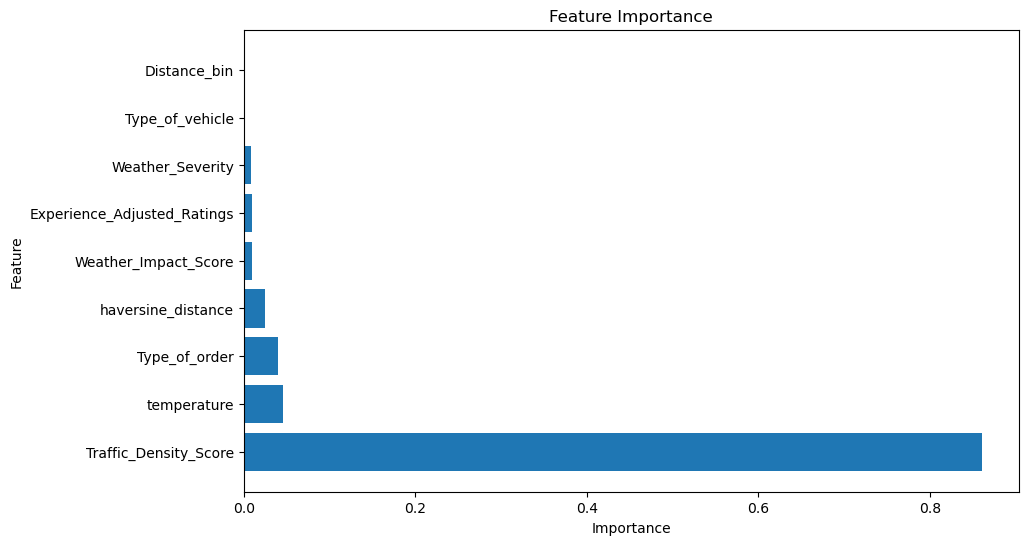

In [25]:
# Creating a bar plot for the feature importance
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


                       Feature  Importance
4        Traffic_Density_Score    1.782135
0                Type_of_order    0.081562
2                  temperature    0.062373
3           haversine_distance    0.035561
5         Weather_Impact_Score    0.009074
8             Weather_Severity    0.007844
6  Experience_Adjusted_Ratings    0.000719
7                 Distance_bin    0.000065
1              Type_of_vehicle   -0.000020


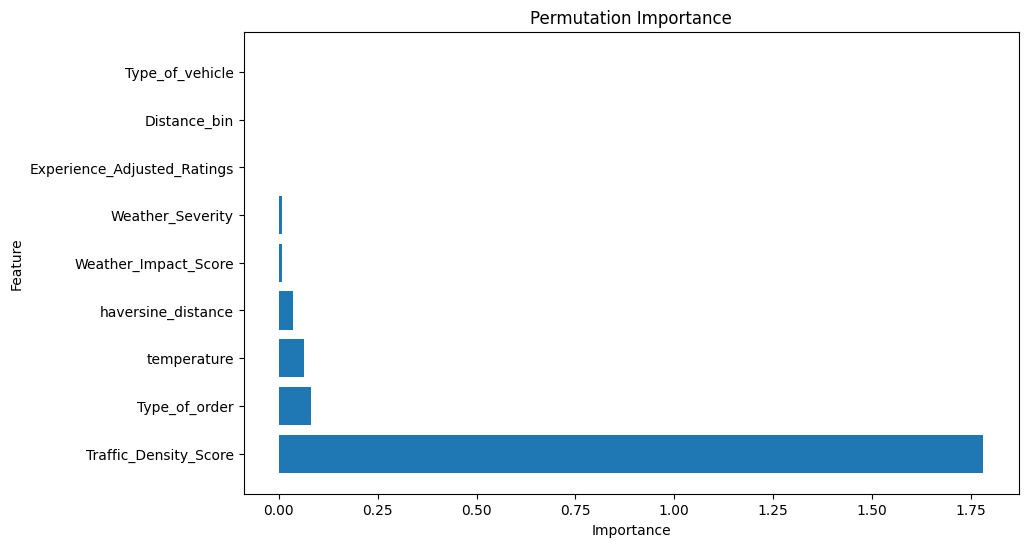

In [24]:
# Checking the feature importance using permutation importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10)

# Create a DataFrame for the importance scores
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
})

# Sort the features by importance
perm_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the top 10 features
print(perm_importance_df.head(10))

# Creating a bar plot for the permutation importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance')
plt.show()

# **Delivery Time Prediction: Model Performance & Feature Insights**

## **1. Analytical Question**
The objective of this analysis is to determine the key factors that influence **delivery time** and develop a predictive model that estimates efficiency based on traffic, weather, and delivery-related variables.


## **2. Feature Engineering**
Several new features were introduced to enhance predictive power:
- **Traffic Density Score**: Measures the combined effect of traffic level and distance.
- **Haversine Distance**: Calculates the geographic distance between restaurant and delivery location.
- **Weather Impact Score**: Aggregates weather conditions affecting deliveries.
- **Experience-Adjusted Ratings**: Evaluates the effect of delivery personnel’s experience on efficiency.
- **Weather Severity Indicator**: Simplifies weather impact using humidity and precipitation.
- **Distance Bin**: Categorizes distances into predefined groups for better analysis.


## **3. Model Performance & Feature Importance**
The **Random Forest model** was trained and evaluated:

- **Train MSE**: **1.99**, **Train R²**: **0.99**
- **Test MSE**: **15.32**, **Test R²**: **0.94**

### **Feature Importance (Random Forest)**
- **Traffic Density Score** (0.86) was the most influential feature.
- **Temperature (0.045)** and **Type of Order (0.040)** had moderate importance.
- **Haversine Distance (0.024)** contributed meaningfully.
- **Weather-related and experience-based features** had low impact.

### **Feature Importance (Permutation Importance)**
- **Traffic Density Score** remained the top predictor (1.77).
- **Type of Order (0.081)** and **Temperature (0.063)** followed.
- **Haversine Distance (0.0348)** was again significant.
- **Distance Bin (0.000072)** and **Type of Vehicle (-0.000004)** contributed very little.

## **4. Insights & Overfitting Considerations**
- **Traffic dominates predictions**: Traffic Density Score significantly influences delivery time.
- **Haversine Distance validates distance-based delays**: Strong importance in both methods.
- **Weather conditions have minimal impact**: Delivery time is not heavily affected by humidity, precipitation, or weather descriptions.
- **Experience-Adjusted Ratings contribute little**: Age and ratings of delivery personnel were not strong predictors.
- **Feature redundancy detected**: Traffic Density Score and Haversine Distance capture similar information, suggesting possible simplification.
- **Minor overfitting observed**: The test error (MSE = 15.32) is notably higher than the train error (MSE = 1.99), indicating potential for regularization.


### **Final Conclusion**
This analysis successfully identified **Traffic Density Score, Haversine Distance, and Type of Order** as the most critical factors influencing delivery time. While weather-related and experience-based features were less impactful, their inclusion helped validate their limited effect. The model performed well, but **overfitting and feature redundancy** suggest areas for refinement in future iterations.
